In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
cd /content/gdrive/My Drive

/content/gdrive/My Drive/UTAH_CSV_DATA


In [ ]:
!pip install dlisio

In [ ]:
#dependencies
%matplotlib inline

import re
import os
import pandas as pd
import dlisio
dlisio.set_encodings(['latin1'])
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import numpy.lib.recfunctions as rfn

In [ ]:
filepath = 'University_of_Utah_MU_ESW1_FMI_HD_7440_7550ft_Run2.dlis'

In [ ]:
#read DLIS file
with dlisio.load(filepath) as file:
    for d in file:
        image_channels = d.match('FMI_DYN')
        for channel in image_channels:
            print(channel.name)
            image_array = channel.curves()

/usr/local/lib/python3.6/dist-packages/dlisio/file.py:321: FutureWarning: match is deprecated and will be removed in a future version, use find('CHANNEL', 'FMI_DYN') instead
  warnings.warn(msg, FutureWarning)


FMI_DYN


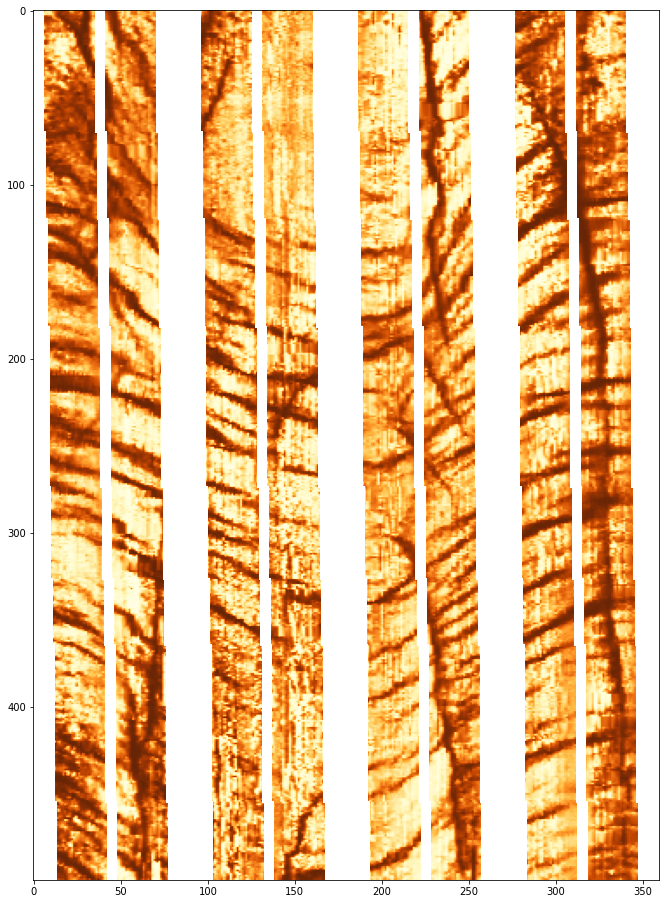

In [ ]:
# Replacing all the values -9999 with nan and plotting a subsection of the data
plt.figure(figsize = (12,16))
image_array[image_array == -9999] = np.nan
plt.imshow(image_array[5000:5500,:], cmap='YlOrBr')

In [ ]:
# reducing white space gap
img=image_array[3800:4300]
img1=img[:,~np.all(np.isnan(img), axis=0)]

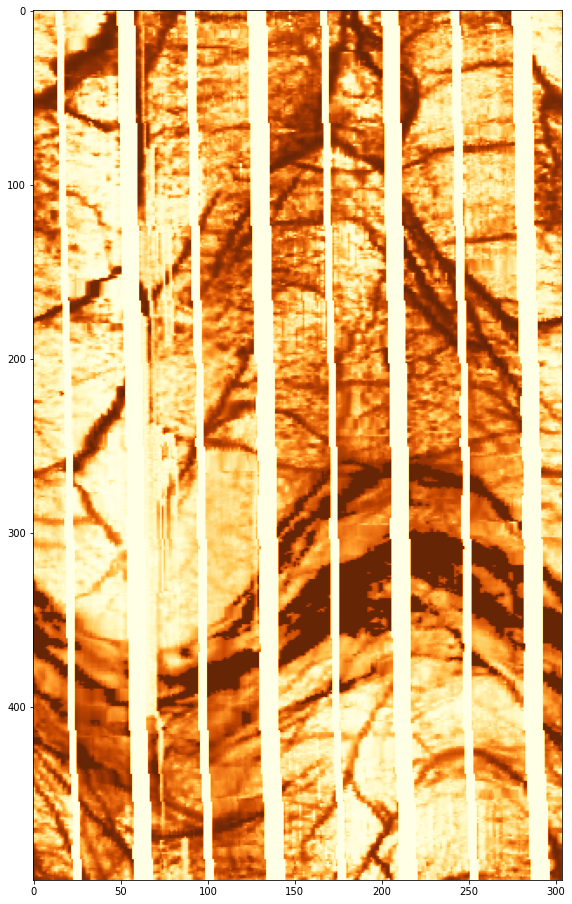

In [ ]:
#plot & save
plt.figure(figsize = (12,16))
img = img1.astype(np.uint8)
plt.imshow(img, cmap='YlOrBr')
#plt.show()
plt.imsave("fmi1/input_img_6.png",img,cmap='YlOrBr')

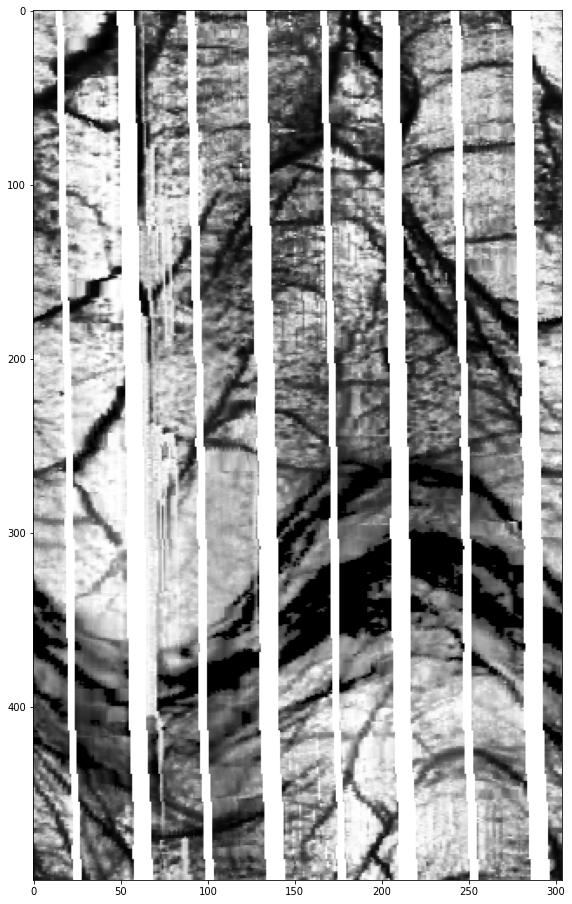

In [ ]:
#grayscale coversion
plt.figure(figsize = (12,16))
img=255-img
plt.imshow(img,cmap='gray')
plt.imsave("fmi1/img_greyscale_6.png",img)

In [ ]:
# from scipy import ndimage, misc
# import matplotlib.pyplot as plt
# fig = plt.figure()
# plt.gray()  # show the filtered result in grayscale
# ax1 = fig.add_subplot(121)  # left side
# ax2 = fig.add_subplot(122)  # right side
# #ascent = misc.ascent()
# result = ndimage.median_filter(image, size=5)
# ax1.imshow(image)
# ax2.imshow(result)
# plt.show()

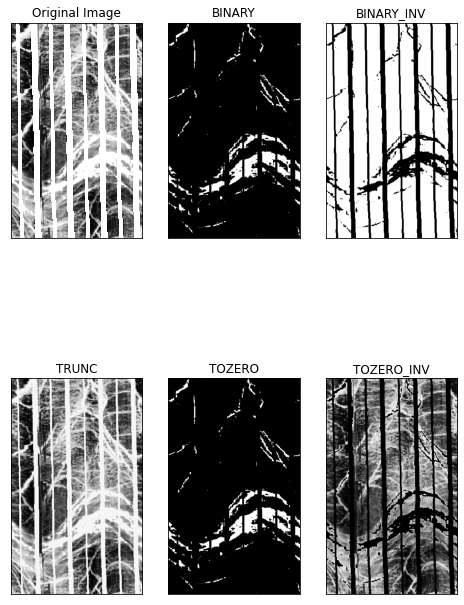

In [ ]:
# thresholding
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = img1
ret,thresh1 = cv2.threshold(img,245,255,cv2.THRESH_BINARY)
ret,thresh2 = cv2.threshold(img,245,255,cv2.THRESH_BINARY_INV)
ret,thresh3 = cv2.threshold(img,245,255,cv2.THRESH_TRUNC)
ret,thresh4 = cv2.threshold(img,245,255,cv2.THRESH_TOZERO)
ret,thresh5 = cv2.threshold(img,245,255,cv2.THRESH_TOZERO_INV)

titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [img, thresh1, thresh2, thresh3, thresh4, thresh5]
plt.figure(figsize = (8,12))
for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(images[i],'gray',vmin=0,vmax=255)
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()



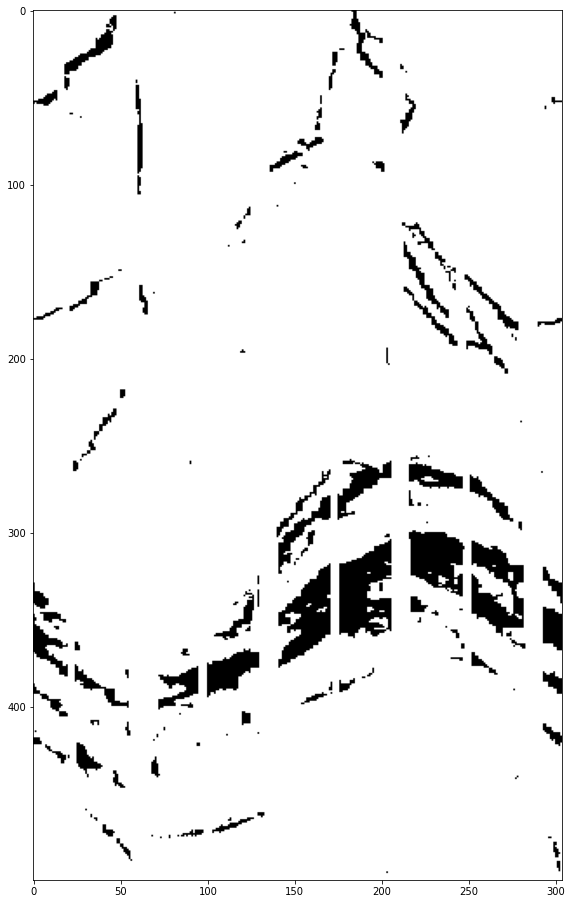

In [ ]:
# binary thresholding & save
img_bw=255-images[1]
img = img_bw.astype(np.uint8)
plt.figure(figsize = (12,16))
plt.imshow(img_bw)
plt.imsave("fmi1/output_img_6.png",img_bw)

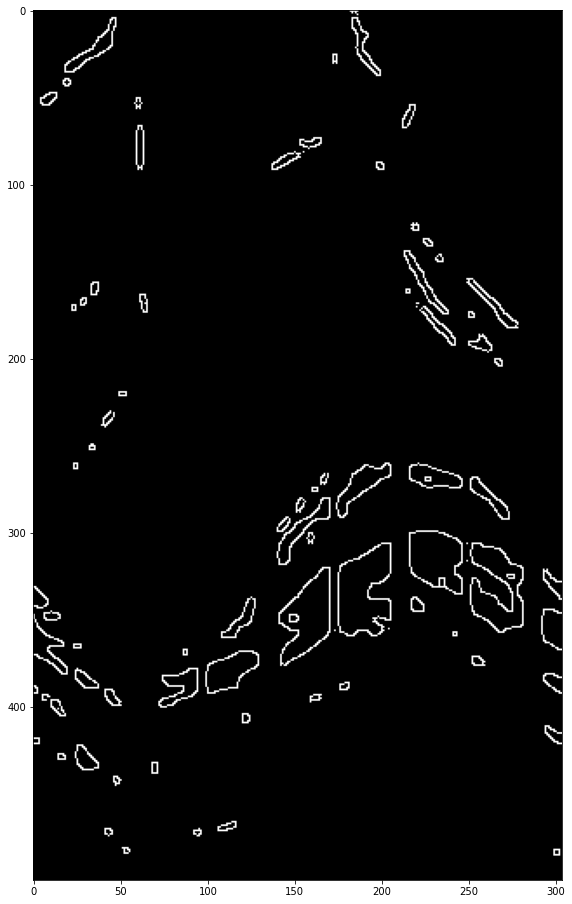

In [ ]:
 # canny edge detection  & houghs transformation
from google.colab.patches import cv2_imshow
img = img_bw.astype(np.uint8)
img=cv2.medianBlur(img,5)
edges = cv2.Canny(img,200,255,apertureSize = 7)
minLineLength = 30
maxLineGap = 5
lines = cv2.HoughLinesP(edges,cv2.HOUGH_PROBABILISTIC, np.pi/180, 30, minLineLength,maxLineGap)
x_data= []
y_data=[]
i=0;
fig=images[1]
for x in range(0, len(lines)):
    for x1,y1,x2,y2 in lines[x]:
      x_data.append(x1)
      y_data.append(y1)
      
      x_data.append(x2)
      y_data.append(y2)
      #cv2.line(inputImage,(x1,y1),(x2,y2),(0,128,0),2, cv2.LINE_AA)
      pts = np.array([[x1, y1 ], [x2 , y2]], np.int32)
      
      #cv2.polylines(fig, [pts], False, (125,120,100),5)
#plt.figure(figsize = (12,16))
#plt.scatter(x_data,y_data,color='b')
plt.figure(figsize = (12,16))
plt.imshow(edges)
plt.imsave("fmi1/edge_img_6.png",edges)

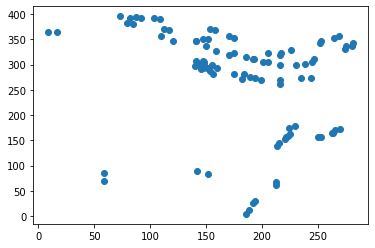

In [ ]:
# data for curve fitting
plt.scatter(x_data, y_data, label='Data')
plt.show()

In [ ]:
x_data=np.asarray(x_data)
y_data=np.asarray(y_data)

[ 3.75195187e+00 -3.45682114e-02  7.86592663e-05  2.38691222e+02]


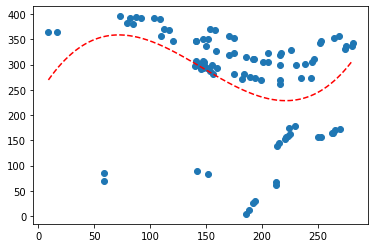

In [ ]:
# fit a line to the economic data
from numpy import sin
from numpy import sqrt
from numpy import arange
from pandas import read_csv
from scipy.optimize import curve_fit
from matplotlib import pyplot
 
# define the true objective function
def objective(x, a, b, c, d):
	return (a * x) + (b * x**2) + (c * x**3)+d
 
# load the dataset
# choose the input and output variables
x, y = x_data,y_data
# curve fit
popt, _ = curve_fit(objective, x, y)
# summarize the parameter values
a, b, c,d = popt
print(popt)
# plot input vs output
plt.scatter(x, y)
# define a sequence of inputs between the smallest and largest known inputs
x_line = arange(min(x), max(x), 1)
# calculate the output for the range
y_line = objective(x_line, a, b, c,d)
# create a line plot for the mapping function
plt.plot(x_line, y_line, '--', color='red')
plt.show()

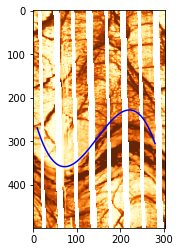

In [ ]:
# plot of curve on raw data
plt.plot(x_line, y_line, '-', color='blue')
plt.imshow(img1,cmap='YlOrBr')
plt.show()